In [1]:
import os
import pandas as pd
import cv2
import glob
import time
import math
import numpy as np
from PIL import Image
import keras
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input,Flatten,Dropout
from keras.models import Model, Sequential
from keras.applications import ResNet50
from keras.applications import ResNet152
from keras.layers import concatenate
from keras.utils import plot_model
#Inception Model
from keras.applications import InceptionV3
from keras.utils import plot_model

In [2]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 1.75,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 1.75,
                         (img_height + crop_height) // 2))


def crop_max_square(pil_img):
    return crop_center(pil_img, min(pil_img.size), min(pil_img.size))
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def append_fileinfo(fn,path):
    return path + fn+".jpg"

def append_superpixelinfo(fn,path):
    return path + fn + ".png"    

#dir(keras.applications)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/ResizedImages-20230403T182719Z-001/ResizedImages/"

Mounted at /content/drive
ISIC_0000000.jpg  ISIC_0009974.jpg  ISIC_0013023.jpg
ISIC_0000001.jpg  ISIC_0009975.jpg  ISIC_0013024.jpg
ISIC_0000002.jpg  ISIC_0009976.jpg  ISIC_0013025.jpg
ISIC_0000003.jpg  ISIC_0009977.jpg  ISIC_0013026.jpg
ISIC_0000004.jpg  ISIC_0009979.jpg  ISIC_0013027.jpg
ISIC_0000006.jpg  ISIC_0009981.jpg  ISIC_0013031.jpg
ISIC_0000007.jpg  ISIC_0009982.jpg  ISIC_0013032.jpg
ISIC_0000008.jpg  ISIC_0009987.jpg  ISIC_0013033.jpg
ISIC_0000009.jpg  ISIC_0009991.jpg  ISIC_0013034.jpg
ISIC_0000010.jpg  ISIC_0009993.jpg  ISIC_0013037.jpg
ISIC_0000011.jpg  ISIC_0009994.jpg  ISIC_0013039.jpg
ISIC_0000012.jpg  ISIC_0009998.jpg  ISIC_0013040.jpg
ISIC_0000013.jpg  ISIC_0010000.jpg  ISIC_0013044.jpg
ISIC_0000014.jpg  ISIC_0010002.jpg  ISIC_0013047.jpg
ISIC_0000015.jpg  ISIC_0010003.jpg  ISIC_0013048.jpg
ISIC_0000016.jpg  ISIC_0010005.jpg  ISIC_0013052.jpg
ISIC_0000017.jpg  ISIC_0010006.jpg  ISIC_0013053.jpg
ISIC_0000018.jpg  ISIC_0010011.jpg  ISIC_0013054.jpg
ISIC_0000019.jpg  IS

In [4]:
#Create Full Dataset run
#datapath="./ISIC-2017_Training_Data/"
datapath2 = "./generatedimages"
#datapath = "./imageTest/"
#datapath = "/content/drive/My Drive/Colab Notebooks/imageTest/"
datapath = "/content/drive/My Drive/ResizedImages-20230403T182719Z-001/ResizedImages/"


#filename_read = os.path.join(datapath + "ISIC-2017_Training_Part3_ModGroundTruth.csv")    
filename_read = datapath + "ISIC-2017_Training_Part3_ModGroundTruth.csv"   
dfBase  = pd.read_csv(filename_read)



#Seperate Categories into dataframes
dfNevus = dfBase[dfBase.Nevus == 'Nevus']
dfMelanoma = dfBase[dfBase.melanoma == 'melanoma']
dfSeb = dfBase[dfBase.seborrheic_keratosis == 'seborrheic_keratosis']

#Take smaller set of data and increase representation of Melanoma and Seb records to help with imbalance
dfNevus = dfNevus[0:500]
dfMelanoma = dfMelanoma[0:250]
dfSeb = dfSeb[0:250]
df = pd.concat([dfNevus, dfMelanoma, dfSeb])

df=shuffle(df)

df['filename'] = df['image_id'].apply(append_fileinfo,path=datapath)
df = df.drop(['image_id','melanoma', 'seborrheic_keratosis','Nevus'],axis=1)
df= shuffle(df)
print(df)

classlist = ["melanoma", "seborrheic_keratosis","Nevus"]
datagen = ImageDataGenerator(rescale=1./255,rotation_range=180,
                             data_format='channels_last', validation_split=0.25)


train_inc = datagen.flow_from_dataframe(df, x_col='filename', y_col='Category',  classes=classlist, 
                                    class_mode='categorical',  batch_size=32, shuffle=False, 
                                    target_size=(299, 299), save_format='png',
                                   subset="training")

validate_inc =datagen.flow_from_dataframe(df, x_col='filename', y_col='Category', classes=classlist, 
                                    class_mode='categorical',  batch_size=32, shuffle=False, 
                                    target_size=(299, 299), save_format='png',
                                   subset="validation")

                  Category                                           filename
1011              melanoma  /content/drive/My Drive/ResizedImages-20230403...
12                melanoma  /content/drive/My Drive/ResizedImages-20230403...
65                   Nevus  /content/drive/My Drive/ResizedImages-20230403...
521                  Nevus  /content/drive/My Drive/ResizedImages-20230403...
1068  seborrheic_keratosis  /content/drive/My Drive/ResizedImages-20230403...
...                    ...                                                ...
1842  seborrheic_keratosis  /content/drive/My Drive/ResizedImages-20230403...
209                  Nevus  /content/drive/My Drive/ResizedImages-20230403...
1208  seborrheic_keratosis  /content/drive/My Drive/ResizedImages-20230403...
400                  Nevus  /content/drive/My Drive/ResizedImages-20230403...
114                  Nevus  /content/drive/My Drive/ResizedImages-20230403...

[1000 rows x 2 columns]
Found 750 validated image filenames bel

In [5]:
print("num training recs = {}" .format(train_inc.n))
print("size training batch = {}" .format(train_inc.batch_size))
TRAIN_RECS = train_inc.n
BATCH_SIZE = train_inc.batch_size
VALIDATE_RECS = validate_inc.n
TRAIN_STEPS = math.floor(TRAIN_RECS/BATCH_SIZE)
VALIDATE_STEPS = math.floor(VALIDATE_RECS/BATCH_SIZE)
print("Train steps = {}, Validate steps = {}" . format(TRAIN_STEPS, VALIDATE_STEPS))

num training recs = 750
size training batch = 32
Train steps = 23, Validate steps = 7


In [6]:
#Define Models

input_tensor = Input(shape=(299,299,3))
inclayer = InceptionV3(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(299,299,3), pooling=None, classes=3)
for layer in inclayer.layers:
  layer.trainable = True 
inc_l1 = inclayer.output
inc_dense = Dense(24,activation='relu')(inc_l1)
inc_dropout=Dropout(.25)(inc_dense)
inc_dense2 = Dense(12, activation='relu')(inc_dropout)
inc_dropout2 = Dropout(.25)(inc_dense2)
inc_flat = Flatten()(inc_dropout2)
inc_dropout3 = Dropout(.25)(inc_flat)
inc_prediction = Dense(3, activation='softmax')(inc_dropout3)
inc_final_model = Model(inputs=inclayer.input, outputs=inc_prediction)
#inc_final_model.summary()
final_model=inc_final_model
final_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                  

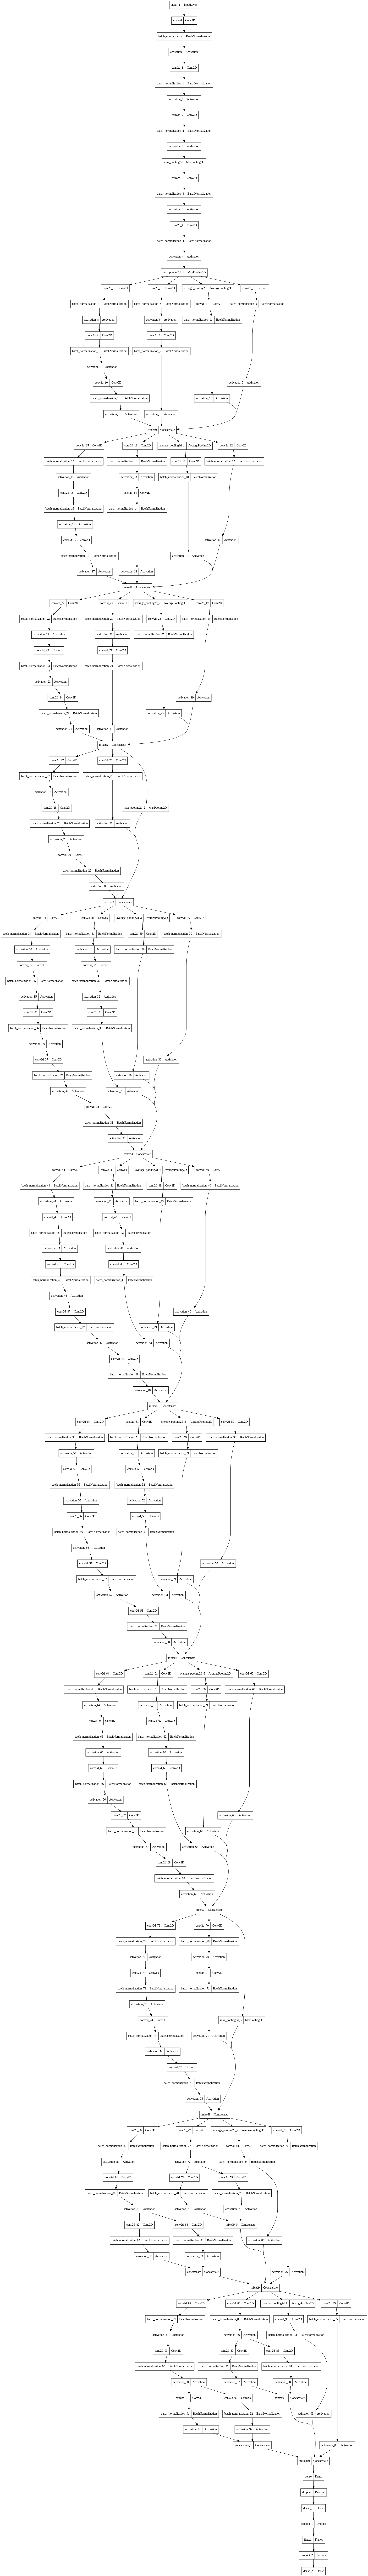

In [7]:
# plot graph
plot_model(final_model, to_file='./inception_inputs_trainable.png')

In [8]:
#Inception Run
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/bestInceptionLessTrainable_weights.hdf5", verbose=0, save_best_only=True) # save best model
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=3, verbose=0, mode='auto',restore_best_weights=True) 
final_model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])


start_time = time.time()
print("Inception Start time: {}",format(hms_string(start_time)))
final_model.fit_generator(generator=train_inc,
                    steps_per_epoch=TRAIN_STEPS,
                    validation_data=validate_inc,
                    validation_steps=VALIDATE_STEPS,
                    epochs=100,
                    workers=3,
                    use_multiprocessing=False,
                    max_queue_size=4,
                    callbacks=[monitor,checkpointer])

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
print("Finished Inception Fit Elapsed time: {}".format(elapsed_time)) 

Inception Start time: {} 466893:01:53.38


<ipython-input-8-f3a44f5240b5>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  final_model.fit_generator(generator=train_inc,


Epoch 1/100
23/23 [==============================] - 934s 39s/step - loss: 1.1109 - accuracy: 0.4457 - val_loss: 1040.5106 - val_accuracy: 0.5402
Epoch 2/100
23/23 [==============================] - 898s 39s/step - loss: 0.9423 - accuracy: 0.5376 - val_loss: 379.9142 - val_accuracy: 0.5402
Epoch 3/100
23/23 [==============================] - 898s 39s/step - loss: 0.9270 - accuracy: 0.5724 - val_loss: 29.6913 - val_accuracy: 0.5402
Epoch 4/100
23/23 [==============================] - 893s 39s/step - loss: 0.7670 - accuracy: 0.6797 - val_loss: 5.1627 - val_accuracy: 0.5625
Epoch 5/100
23/23 [==============================] - 871s 38s/step - loss: 0.7165 - accuracy: 0.7061 - val_loss: 16.2125 - val_accuracy: 0.5804
Epoch 6/100
23/23 [==============================] - 887s 38s/step - loss: 0.7145 - accuracy: 0.6866 - val_loss: 1068.4050 - val_accuracy: 0.5402
Epoch 7/100
23/23 [==============================] - 891s 39s/step - loss: 0.6351 - accuracy: 0.7173 - val_loss: 2.7853 - val_accura

In [9]:
#Perform Prediction

test_generator = validate_inc

final_model.load_weights("/content/drive/My Drive/Colab Notebooks/bestInceptionLessTrainable_weights.hdf5")
pred = final_model.predict_generator(test_generator, steps=VALIDATE_STEPS)
rawpred = np.argmax(pred,axis=1)
print(pred)
print(rawpred)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in rawpred]
print(predictions)

<ipython-input-9-0898e4a85be6>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = final_model.predict_generator(test_generator, steps=VALIDATE_STEPS)


[[1.12249240e-01 1.42642464e-02 8.73486519e-01]
 [3.27942669e-02 2.14337226e-04 9.66991425e-01]
 [8.12755749e-02 6.21929951e-02 8.56531262e-01]
 [7.13749509e-03 2.07435805e-05 9.92841661e-01]
 [1.08185075e-02 9.84945714e-01 4.23573423e-03]
 [1.08706625e-02 9.79625225e-01 9.50405747e-03]
 [1.52136600e-02 9.72601891e-01 1.21844811e-02]
 [2.25587152e-02 9.47622478e-01 2.98186839e-02]
 [4.51474607e-01 4.11840767e-01 1.36684567e-01]
 [1.99616905e-02 5.70304459e-04 9.79468048e-01]
 [6.43654587e-03 9.88866091e-01 4.69725672e-03]
 [2.53209081e-02 1.73779015e-04 9.74505305e-01]
 [9.71111190e-03 9.84842718e-01 5.44621376e-03]
 [2.01204270e-02 4.59340168e-04 9.79420245e-01]
 [2.21377388e-01 1.17192166e-02 7.66903400e-01]
 [9.51443389e-02 7.03812391e-03 8.97817433e-01]
 [2.00116634e-02 4.41648299e-04 9.79546785e-01]
 [1.45270109e-01 3.76562099e-03 8.50964248e-01]
 [5.76844066e-02 3.10939015e-03 9.39206183e-01]
 [1.67765208e-02 9.23573243e-05 9.83131170e-01]
 [6.88884594e-03 9.90242362e-01 2.868759

In [10]:
#Evaluate Model
eval = final_model.evaluate_generator(test_generator, steps=VALIDATE_STEPS)
print(final_model.metrics_names)
eval

<ipython-input-10-2bc31f8cd9b3>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  eval = final_model.evaluate_generator(test_generator, steps=VALIDATE_STEPS)


['loss', 'accuracy']


[0.7526518106460571, 0.7276785969734192]

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
l= test_generator.class_indices.keys()
print(l)
y_tru = test_generator.classes[0:224]
cm = confusion_matrix(y_tru, rawpred)
print(cm)
print(classification_report(y_tru, rawpred))

dict_keys(['melanoma', 'seborrheic_keratosis', 'Nevus'])
[[  6  16  33]
 [  0  44   4]
 [  2   5 114]]
              precision    recall  f1-score   support

           0       0.75      0.11      0.19        55
           1       0.68      0.92      0.78        48
           2       0.75      0.94      0.84       121

    accuracy                           0.73       224
   macro avg       0.73      0.66      0.60       224
weighted avg       0.74      0.73      0.67       224



In [12]:
#AUC Metrics
def convert_tobinary(x):
    if (x > 0).bool():
        return 1
    else:
        return 0

#Convert 3 classification to binary for ROC_AUC
dftrue = pd.DataFrame(y_tru, dtype=int);
dfpred = pd.DataFrame(rawpred, dtype=int);
dftrue = dftrue.apply(convert_tobinary,axis=1)
dfpred = dfpred.apply(convert_tobinary,axis=1)

from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=dftrue,  y_score=dfpred, average='samples')

0.5486282947821409